In [1]:
### 라이브러리 선언

import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format='retina'

from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim

from torchinfo import summary
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [2]:
### DefineV Optimized CAE Parameters

SEED = 42

INITIAL_LR = 0.000647615515510681
EPOCHS = 100
BATCH_SIZE = 75

NUM_CHANNELS_1 = 60
NUM_CHANNELS_2 = 38
NUM_CHANNELS_3 = 24
NUM_CHANNELS_4 = 34

WEIGHT_DECAY = 0.08558187708034752
BETA1 = 0.911219148551416
BETA2 = 0.9991991007849765
SCHEDULER_FACTOR = 0.19414438105283446
SCHEDULER_PATIENCE = 3
AMSGRAD = False

NUM_SAMPLES = 10

In [3]:
### Random Control

def fix_seed(your_seed):
    
    # NumPy Seed 고정
    np.random.seed(your_seed)
    
    # Random Seed 고정(for torchvision transforms)
    random.seed(your_seed)

    # PyTorch Seed 고정
    torch.manual_seed(your_seed)
    torch.cuda.manual_seed_all(your_seed)
    
    # CuDNN Seed 고정
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

fix_seed(SEED)

In [4]:
### Convolutional Auto Encoder Model

class ConvolutionalAutoEncoder(nn.Module):

    def __init__(self, num_channels_1, num_channels_2, num_channels_3, num_channels_4):
        super(ConvolutionalAutoEncoder, self).__init__()

        self.encoder1 = nn.Sequential()
        self.encoder1.add_module('Encoder1-Conv1d', nn.Conv1d(in_channels=1, out_channels=num_channels_1, kernel_size=4, stride=4, padding=0))
        self.encoder1.add_module('Encoder1-ELU', nn.ELU(inplace=True))

        self.encoder2 = nn.Sequential()
        self.encoder2.add_module('Encoder2-Conv1d', nn.Conv1d(in_channels=num_channels_1, out_channels=num_channels_2, kernel_size=5, stride=5, padding=0))
        self.encoder2.add_module('Encoder2-ELU', nn.ELU(inplace=True))

        self.encoder3 = nn.Sequential()
        self.encoder3.add_module('Encoder3-Conv1d', nn.Conv1d(in_channels=num_channels_2, out_channels=num_channels_3, kernel_size=8, stride=8, padding=0))
        self.encoder3.add_module('Encoder3-PReLU', nn.PReLU(num_parameters=num_channels_3))

        self.encoder4 = nn.Sequential()
        self.encoder4.add_module('Encoder4-Conv1d', nn.Conv1d(in_channels=num_channels_3, out_channels=num_channels_4, kernel_size=10, stride=10, padding=0))
        self.encoder4.add_module('Encoder4-LeakyReLU', nn.LeakyReLU(negative_slope=0.01, inplace=True))

        self.decoder1 = nn.Sequential()
        self.decoder1.add_module('Decoder1-Conv1d', nn.ConvTranspose1d(in_channels=num_channels_4, out_channels=num_channels_3, kernel_size=10, stride=10, padding=0))
        self.decoder1.add_module('Decoder1-ReLU', nn.ReLU(inplace=True))

        self.decoder2 = nn.Sequential()
        self.decoder2.add_module('Decoder2-Conv1d', nn.ConvTranspose1d(in_channels=num_channels_3, out_channels=num_channels_2, kernel_size=8, stride=8, padding=0))
        self.decoder2.add_module('Decoder2-ReLU', nn.ReLU(inplace=True))
        
        self.decoder3 = nn.Sequential()
        self.decoder3.add_module('Decoder3-Conv1d', nn.ConvTranspose1d(in_channels=num_channels_2, out_channels=num_channels_1, kernel_size=5, stride=5, padding=0))
        self.decoder3.add_module('Decoder3-ReLU', nn.ReLU(inplace=True))

        self.decoder4 = nn.Sequential()
        self.decoder4.add_module('Decoder4-Conv1d', nn.ConvTranspose1d(in_channels=num_channels_1, out_channels=1, kernel_size=4, stride=4, padding=0))

    def forward(self, X):
        X_encoder1 = self.encoder1(X)
        X_encoder2 = self.encoder2(X_encoder1)
        X_encoder3 = self.encoder3(X_encoder2)
        X_encoder4 = self.encoder4(X_encoder3)
        X_decoder1 = self.decoder1(X_encoder4)
        X_decoder2 = self.decoder2(X_decoder1)
        X_decoder3 = self.decoder3(X_decoder2)
        X_decoder4 = self.decoder4(X_decoder3)
        
        return X_decoder4
    
    def num_of_parameters(self):
        return (sum(p.numel() for p in self.parameters() if p.requires_grad))

In [5]:
### Visualize the Optimized CAE Model Architecture

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Visualize_Optimized_CAE = ConvolutionalAutoEncoder(NUM_CHANNELS_1, NUM_CHANNELS_2, NUM_CHANNELS_3, NUM_CHANNELS_4).to(device)
summary(Visualize_Optimized_CAE, (BATCH_SIZE, 1, 1600))

Layer (type:depth-idx)                   Output Shape              Param #
ConvolutionalAutoEncoder                 [75, 1, 1600]             --
├─Sequential: 1-1                        [75, 60, 400]             --
│    └─Conv1d: 2-1                       [75, 60, 400]             300
│    └─ELU: 2-2                          [75, 60, 400]             --
├─Sequential: 1-2                        [75, 38, 80]              --
│    └─Conv1d: 2-3                       [75, 38, 80]              11,438
│    └─ELU: 2-4                          [75, 38, 80]              --
├─Sequential: 1-3                        [75, 24, 10]              --
│    └─Conv1d: 2-5                       [75, 24, 10]              7,320
│    └─PReLU: 2-6                        [75, 24, 10]              24
├─Sequential: 1-4                        [75, 34, 1]               --
│    └─Conv1d: 2-7                       [75, 34, 1]               8,194
│    └─LeakyReLU: 2-8                    [75, 34, 1]               --
├─Se

In [6]:
### Early Stopping 선언

class EarlyStopping():
    
    def __init__(self, patience=10, delta=0, verbose=False, path='CAE_Checkpoint.pt'):
        
        self.patience = patience
        self.delta = delta
        self.verbose = verbose
        self.path = path
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.min_valid_loss = np.inf

    def __call__(self, valid_loss, model):
        
        score = -valid_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(valid_loss, model)
        elif score < self.best_score+self.delta:
            self.counter += 1
            print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            best_score = score
            self.save_checkpoint(valid_loss, model)
            self.counter = 0

    def save_checkpoint(self, valid_loss, model):
        
        if self.verbose:
            print(f"Validation loss decreased ({self.min_valid_loss:.10f} --> {valid_loss:.10f}). Saving model ...")

        torch.save(model.state_dict(), self.path)
        self.val_loss_min = valid_loss        

In [7]:
### Convolutional Auto Enocder Runner 선언

class ConvolutionalAutoEncoderRunner():
    
    def __init__(self):

        X_Train = np.load("Normalized_X_Train.npy")
        X_Valid = np.load("Normalized_X_Valid.npy")

        self.train_ds = torch.from_numpy(X_Train).float().unsqueeze(1)
        self.valid_ds = torch.from_numpy(X_Valid).float().unsqueeze(1)

    def save_encoder_output(self, model, dataloader, save_path):
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.eval()
        latent_vectors = []

        with torch.no_grad():
            for batch_index, batch_data in enumerate(dataloader):
                inputs = batch_data.to(device)
                X_encoder1 = model.module.encoder1(inputs)
                X_encoder2 = model.module.encoder2(X_encoder1)
                X_encoder3 = model.module.encoder3(X_encoder2)
                X_encoder4 = model.module.encoder4(X_encoder3)

                latent_vector = X_encoder4.squeeze().cpu().numpy()
                latent_vectors.append(latent_vector)
        
        latent_vectors = np.concatenate(latent_vectors, axis=0)        
        np.save(save_path, latent_vectors)
        print(f"[INFO] Latent Vectors from the Encoder Output is saved to {save_path}")

    def train(
        self, 
        initial_lr, epochs, batch_size, 
        num_channels_1, num_channels_2, num_channels_3, num_channels_4, 
        weight_decay, beta1, beta2, scheduler_factor, scheduler_patience, amsgrad
    ):
        
        self.initial_lr = initial_lr
        self.epochs = epochs
        self.batch_size = batch_size

        self.num_channels_1 = num_channels_1
        self.num_channels_2 = num_channels_2
        self.num_channels_3 = num_channels_3
        self.num_channels_4 = num_channels_4

        self.weight_decay = weight_decay
        self.beta1 = beta1
        self.beta2 = beta2
        self.scheduler_factor = scheduler_factor
        self.scheduler_patience = scheduler_patience
        self.amsgrad = amsgrad

        torch.cuda.empty_cache()

        self.train_loader = DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=True)
        self.valid_loader = DataLoader(self.valid_ds, batch_size=self.batch_size, shuffle=False)

        self.train_loader_encoder_output = DataLoader(self.train_ds, batch_size=self.batch_size, shuffle=False)
        self.valid_loader_encoder_output = DataLoader(self.valid_ds, batch_size=self.batch_size, shuffle=False)

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        cae_model = ConvolutionalAutoEncoder(
            num_channels_1=self.num_channels_1,
            num_channels_2=self.num_channels_2,
            num_channels_3=self.num_channels_3,
            num_channels_4=self.num_channels_4
        )

        num_of_parameters = cae_model.num_of_parameters()

        model = nn.DataParallel(cae_model)
        model.to(device)

        criterion = nn.MSELoss().to(device)

        optimizer = optim.AdamW(
            model.parameters(),
            lr=self.initial_lr,
            betas=(self.beta1, self.beta2), eps=1e-8,
            weight_decay=self.weight_decay,
            amsgrad=self.amsgrad
        )

        scheduler = ReduceLROnPlateau(
            optimizer=optimizer,
            mode='min',
            factor=self.scheduler_factor,
            patience=self.scheduler_patience
        )

        os.makedirs('./EarlyStopping_Checkpoint', exist_ok=True)
        early_stopping = EarlyStopping(
            patience=10,
            delta=0,
            path='./EarlyStopping_Checkpoint/Best_CAE_Checkpoint'
        )

        history_loss = {'train_loss': [], 'valid_loss': []}
        history_accuracy = {'train_accuracy': [], 'valid_accuracy': []}

        total_start = time.time()

        optimizer.zero_grad()
        model.train()

        final_train_loss = []
        final_valid_loss = []
        
        final_train_accuracy = []
        final_valid_accuracy = []

        for epoch in range(1, 1+self.epochs):
            
            epoch_start = time.time()

            train_losses = []
            for train_batch_index, train_batch_data in enumerate(self.train_loader):
                train_inputs = train_batch_data.to(device)
                optimizer.zero_grad()
                train_X_decoder4 = model(train_inputs)
                train_loss = criterion(train_X_decoder4, train_inputs)
                train_loss.backward()
                optimizer.step()
                train_losses.append(train_loss.item())
                final_train_loss.append(train_loss.item())
            epoch_train_loss = np.mean(train_losses)
            history_loss['train_loss'].append(epoch_train_loss)

            model.eval()
            valid_losses = []
            with torch.no_grad():
                for valid_batch_index, valid_batch_data in enumerate(self.valid_loader):
                    valid_inputs = valid_batch_data.to(device)
                    valid_X_decoder4 = model(valid_inputs)
                    valid_loss = criterion(valid_X_decoder4, valid_inputs)
                    valid_losses.append(valid_loss.item())
                    final_valid_loss.append(valid_loss.item())
            epoch_valid_loss = np.mean(valid_losses)
            history_loss['valid_loss'].append(epoch_valid_loss)

            scheduler.step(epoch_valid_loss)

            early_stopping(epoch_valid_loss, model)

            if early_stopping.early_stop:
                print(f"Early stopping at epoch {epoch}")
                break

            epoch_train_accuracy = self.evaluate_accuracy(model, self.train_loader, 0.99)
            epoch_valid_accuracy = self.evaluate_accuracy(model, self.valid_loader, 0.99)
            final_train_accuracy.append(epoch_train_accuracy)
            final_valid_accuracy.append(epoch_valid_accuracy)
            history_accuracy['train_accuracy'].append(epoch_train_accuracy)
            history_accuracy['valid_accuracy'].append(epoch_valid_accuracy)

            epoch_time = time.time() - epoch_start

            if epoch < 10:
                print(f"Epoch [0{epoch}/{self.epochs}] | Train Loss: {epoch_train_loss:.10f} | Valid Loss: {epoch_valid_loss:.10f} | Time: {epoch_time:.5f}s")
                print(f"Epoch [0{epoch}/{self.epochs}] | Train Accuracy: {epoch_train_accuracy:.10f} | Valid Accuracy: {epoch_valid_accuracy:.10f}")
            else:
                print(f"Epoch [{epoch}/{self.epochs}] | Train Loss: {epoch_train_loss:.10f} | Valid Loss: {epoch_valid_loss:.10f} | Time: {epoch_time:.5f}s")
                print(f"Epoch [{epoch}/{self.epochs}] | Train Accuracy: {epoch_train_accuracy:.10f} | Valid Accuracy: {epoch_valid_accuracy:.10f}")

        mean_train_loss = np.mean(final_train_loss)
        mean_valid_loss = np.mean(final_valid_loss)
        mean_train_accuracy = np.mean(final_train_accuracy)
        mean_valid_accuracy = np.mean(final_valid_accuracy)        
        
        total_time = time.time() - total_start

        print(f"Total time: {total_time:.5f}s")
        print(f"Number of Parameters: {num_of_parameters}")
        print(f"Best HyperParameters of Train [Batch Size: {self.batch_size} / Learning Rate: {self.initial_lr} / Epoch: {self.epochs}]")
        print(f"Best HyperParameters of Model [#1: {self.num_channels_1} / #2: {self.num_channels_2} / #3: {self.num_channels_3} / #4: {self.num_channels_4}]")
        print(f"Mean Loss [Train: {mean_train_loss} / Valid: {mean_valid_loss}]")
        print(f"Mean Accuracy[Train: {mean_train_accuracy} / Valid: {mean_valid_accuracy}]")
        
        self.save_encoder_output(model, self.train_loader_encoder_output, save_path='CAE_Encoder_Output_Train')
        self.save_encoder_output(model, self.valid_loader_encoder_output, save_path='CAE_Encoder_Output_Valid')

        return model, history_loss, history_accuracy

    def evaluate_accuracy(self, model, dataloader, threshold):

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        model.eval()
        differences = []
        cos_sim = nn.CosineSimilarity(dim=2)

        with torch.no_grad():
            for batch_index, batch_data in enumerate(dataloader):
                inputs = batch_data.to(device)
                X_decoder4 = model(inputs)
                difference = cos_sim(inputs, X_decoder4).cpu().numpy()
                difference = difference.reshape(-1)
                differences.extend(difference.tolist())
            pred_score = np.where(np.array(differences)>threshold, 1.0, 0.0)
            true_score = np.ones_like(pred_score)
            pred_score = np.array(pred_score).ravel().tolist()
            true_score = np.array(true_score).ravel().tolist()

        return f1_score(true_score, pred_score, average='macro')

In [8]:
### Execute Model

Optimized_CAE = ConvolutionalAutoEncoderRunner()
optimized_cae_model, optimized_history_loss, optimized_history_accuracy = Optimized_CAE.train(
    INITIAL_LR, EPOCHS, BATCH_SIZE,
    NUM_CHANNELS_1, NUM_CHANNELS_2, NUM_CHANNELS_3, NUM_CHANNELS_4, 
    WEIGHT_DECAY, BETA1, BETA2, SCHEDULER_FACTOR, SCHEDULER_PATIENCE, AMSGRAD
)

Epoch [01/100] | Train Loss: 0.0028457674 | Valid Loss: 0.0009222438 | Time: 1.72896s
Epoch [01/100] | Train Accuracy: 0.2969172526 | Valid Accuracy: 0.2999377722
Epoch [02/100] | Train Loss: 0.0002459965 | Valid Loss: 0.0000238608 | Time: 1.44341s
Epoch [02/100] | Train Accuracy: 0.4985933388 | Valid Accuracy: 1.0000000000
Epoch [03/100] | Train Loss: 0.0000184003 | Valid Loss: 0.0000167259 | Time: 1.44121s
Epoch [03/100] | Train Accuracy: 0.4988662132 | Valid Accuracy: 1.0000000000
Epoch [04/100] | Train Loss: 0.0000149433 | Valid Loss: 0.0000146987 | Time: 1.45063s
Epoch [04/100] | Train Accuracy: 0.4988662132 | Valid Accuracy: 1.0000000000
Epoch [05/100] | Train Loss: 0.0000137456 | Valid Loss: 0.0000137799 | Time: 1.45553s
Epoch [05/100] | Train Accuracy: 0.4992409308 | Valid Accuracy: 1.0000000000
Epoch [06/100] | Train Loss: 0.0000128831 | Valid Loss: 0.0000126130 | Time: 1.40102s
Epoch [06/100] | Train Accuracy: 0.4990820282 | Valid Accuracy: 1.0000000000
Epoch [07/100] | Train

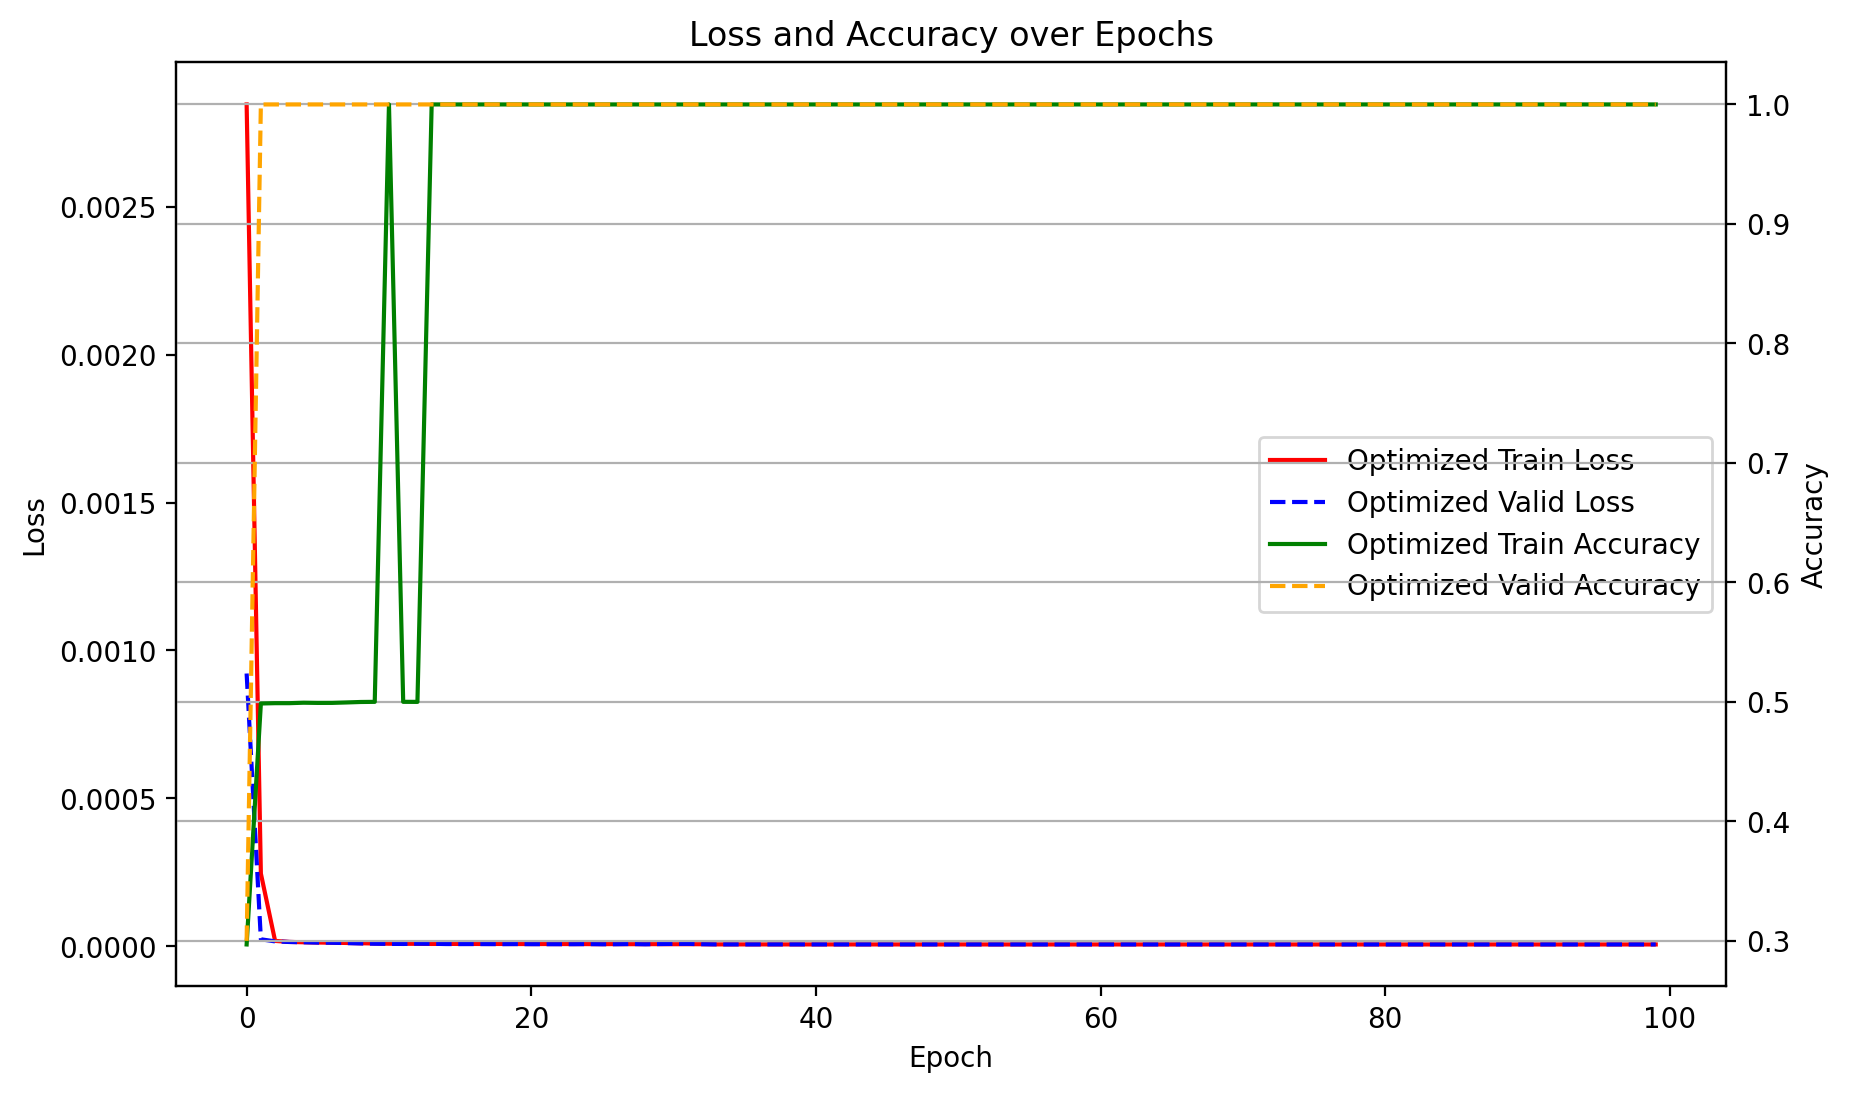

In [9]:
### Check Train Loss and Valid Loss

figure, axis_1 = plt.subplots(figsize=(10, 6))

axis_1.plot(optimized_history_loss['train_loss'], color='red', linestyle='-', linewidth=1.5, label='Optimized Train Loss')
axis_1.plot(optimized_history_loss['valid_loss'], color='blue', linestyle='--', linewidth=1.5, label='Optimized Valid Loss')
axis_1.set_ylabel('Loss', color='black')
axis_1.set_xlabel('Epoch')
axis_1.tick_params(axis='y', labelcolor='black')

axis_2 = axis_1.twinx()
axis_2.plot(optimized_history_accuracy['train_accuracy'], color='green', linestyle='-', linewidth=1.5, label='Optimized Train Accuracy')
axis_2.plot(optimized_history_accuracy['valid_accuracy'], color='orange', linestyle='--', linewidth=1.5, label='Optimized Valid Accuracy')
axis_2.set_ylabel('Accuracy', color='black')
axis_2.tick_params(axis='y', labelcolor='black')

# 범례 통합
lines_1, labels_1 = axis_1.get_legend_handles_labels()
lines_2, labels_2 = axis_2.get_legend_handles_labels()
axis_1.legend(lines_1+lines_2, labels_1+labels_2, loc='center right')

plt.title('Loss and Accuracy over Epochs')
plt.grid(True)
plt.show()

In [10]:
### Convolutional Auto Encoder Tester 선언

class ConvolutionalAutoEncoderTester():
    
    def __init__(self):
        
        X_Test = np.load("Normalized_X_Test.npy")

        self.test_ds = torch.from_numpy(X_Test).float().unsqueeze(1)

    def save_encoder_output(self, model, dataloader, save_path):
        
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.eval()
        latent_vectors = []

        with torch.no_grad():
            for batch_index, batch_data in enumerate(dataloader):
                inputs = batch_data.to(device)
                X_encoder1 = model.module.encoder1(inputs)
                X_encoder2 = model.module.encoder2(X_encoder1)
                X_encoder3 = model.module.encoder3(X_encoder2)
                X_encoder4 = model.module.encoder4(X_encoder3)

                latent_vector = X_encoder4.squeeze().cpu().numpy()
                latent_vectors.append(latent_vector)
        
        latent_vectors = np.concatenate(latent_vectors, axis=0)        
        np.save(save_path, latent_vectors)
        print(f"[INFO] Latent Vectors from the Encoder Output is saved to {save_path}")

    def test(self, model):

        self.batch_size = BATCH_SIZE

        self.test_loader = DataLoader(self.test_ds, batch_size=self.batch_size, shuffle=False)
        
        device = torch.device('cuda') if torch.cuda.is_available() else 'cpu'

        model.to(device)
        
        criterion = nn.MSELoss().to(device)
        
        model.eval()
        test_losses = []
        with torch.no_grad():
            for test_batch_index, test_batch_data in enumerate(self.test_loader):
                test_inputs = test_batch_data.to(device)
                test_X_decoder4 = model(test_inputs)
                test_loss = criterion(test_X_decoder4, test_inputs)
                test_losses.append(test_loss.item())
            
        test_loss = np.mean(test_losses)
        test_accuracy = self.evaluate_accuracy(model, self.test_loader, 0.99)
        
        print(f"Test Results of Optimized CAE [Test Loss: {test_loss:.10f} / Test Accuracy: {test_accuracy:.10f}]")

        self.save_encoder_output(model, self.test_loader, save_path='CAE_Encoder_Output_Test')

        return {'test_loss': test_loss, 'test_accuracy': test_accuracy}
    
    def evaluate_accuracy(self, model, dataloader, threshold):

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        model.eval()
        differences = []
        cos_sim = nn.CosineSimilarity(dim=2)

        with torch.no_grad():
            for batch_index, batch_data in enumerate(dataloader):
                inputs = batch_data.to(device)
                X_decoder4 = model(inputs)
                difference = cos_sim(inputs, X_decoder4).cpu().numpy()
                difference = difference.reshape(-1)
                differences.extend(difference.tolist())
            pred_score = np.where(np.array(differences)>threshold, 1.0, 0.0)
            true_score = np.ones_like(pred_score)
            pred_score = np.array(pred_score).ravel().tolist()
            true_score = np.array(true_score).ravel().tolist()

        return f1_score(true_score, pred_score, average='macro')

In [11]:
### Test Model

Test_Optimized_CAE = ConvolutionalAutoEncoderTester()
Test_Results = Test_Optimized_CAE.test(optimized_cae_model)

Test Results of Optimized CAE [Test Loss: 0.0000064460 / Test Accuracy: 0.4999230651]
[INFO] Latent Vectors from the Encoder Output is saved to CAE_Encoder_Output_Test


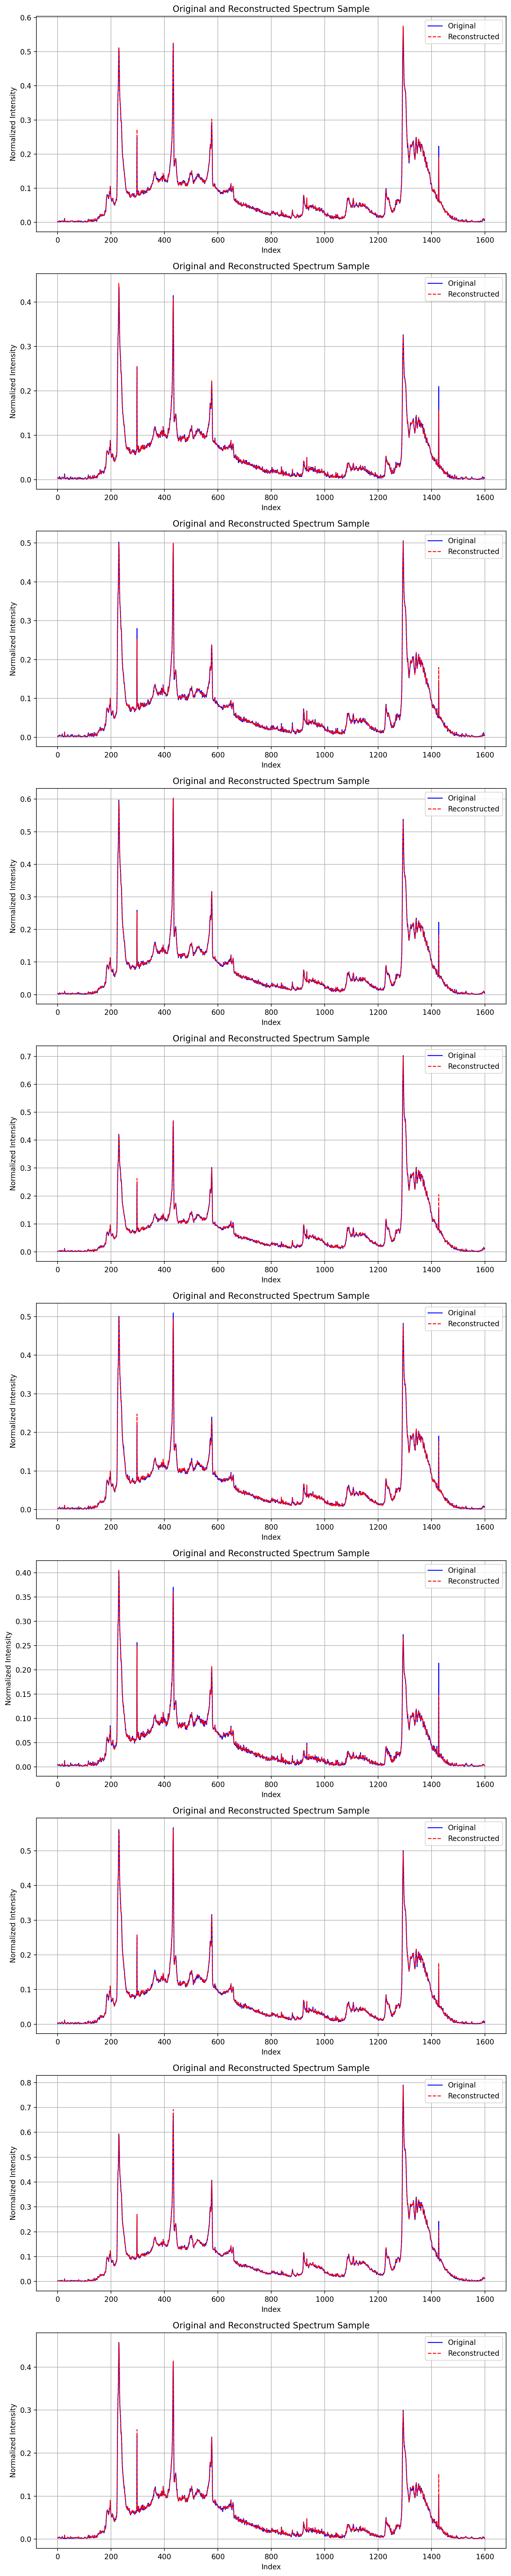

In [12]:
### Reconstruct Spectrum

device = device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X_Test = np.load("Normalized_X_Test.npy")
indices = np.random.choice(len(X_Test), size=NUM_SAMPLES, replace=False)

plt.figure(figsize=(10, 5*NUM_SAMPLES))

for i, index in enumerate(indices):
    original_spectrum = X_Test[index]
    original_spectrum_tensor = torch.from_numpy(original_spectrum).float().to(device)
    
    input_tensor = original_spectrum_tensor.unsqueeze(0).unsqueeze(0)

    with torch.no_grad():
        reconstructed_spectrum = optimized_cae_model(input_tensor)

    original_spectrum = original_spectrum.squeeze()
    reconstructed_spectrum = reconstructed_spectrum.cpu().numpy().squeeze()

    plt.subplot(NUM_SAMPLES, 1, i+1)
    plt.plot(original_spectrum, label='Original', color='blue', linewidth=1.25)
    plt.plot(reconstructed_spectrum, label='Reconstructed', color='red', linestyle='--', linewidth=1.25)
    plt.title(f"Original and Reconstructed Spectrum Sample")
    plt.xlabel("Index")
    plt.ylabel("Normalized Intensity")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

In [13]:
### Check Latent Vector from Encoder Output - Train

CAE_Encoder_Output_Train_df = pd.DataFrame(np.load("CAE_Encoder_Output_Train.npy"))

CAE_Encoder_Output_Train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,-0.156140,16.534767,-0.010640,-0.012049,2.891447,-0.178562,26.419598,-0.024288,10.031213,6.218861,...,18.208576,10.814478,-0.097751,17.425703,-0.020747,16.610279,13.035642,17.882896,-0.022166,17.487078
1,-0.155951,16.547113,-0.010655,-0.012082,2.881508,-0.178640,26.442722,-0.024280,10.042719,6.208799,...,18.222580,10.817617,-0.097766,17.430387,-0.020498,16.628248,13.044123,17.892389,-0.022112,17.504904
2,-0.156113,16.511671,-0.010692,-0.012051,2.915238,-0.178331,26.378366,-0.024379,10.012751,6.205542,...,18.177820,10.860294,-0.097294,17.427929,-0.020570,16.590317,13.017674,17.865307,-0.022148,17.451593
3,-0.155907,16.589722,-0.010710,-0.012057,2.865382,-0.178844,26.494450,-0.024252,10.069077,6.221321,...,18.259083,10.822336,-0.098073,17.447189,-0.020352,16.671507,13.057856,17.924850,-0.022075,17.536716
4,-0.155942,16.502773,-0.010658,-0.012042,2.913279,-0.178385,26.375492,-0.024346,10.005930,6.183622,...,18.175243,10.830143,-0.097291,17.420937,-0.020348,16.580835,13.022322,17.851528,-0.022082,17.462591


In [14]:
### Check Latent Vector from Encoder Output - Valid

CAE_Encoder_Output_Valid_df = pd.DataFrame(np.load("CAE_Encoder_Output_Valid.npy"))

CAE_Encoder_Output_Valid_df.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,-0.161729,15.334382,-0.009843,-0.011678,3.652806,-0.172186,24.723310,-0.025667,9.159897,6.161086,...,17.038584,10.977983,-0.089139,17.111023,-0.027494,15.279666,12.532619,16.964788,-0.024252,16.337154
1,-0.162111,15.304859,-0.009786,-0.011709,3.671523,-0.172093,24.686001,-0.025696,9.141248,6.177338,...,17.015507,10.974429,-0.089060,17.103609,-0.027988,15.245442,12.525786,16.947750,-0.024391,16.312893
2,-0.161627,15.282157,-0.009792,-0.011657,3.643762,-0.171652,24.637228,-0.025613,9.132418,6.178109,...,16.985085,10.938451,-0.089036,17.051199,-0.028039,15.224014,12.492207,16.915413,-0.024336,16.276375
3,-0.161650,15.318786,-0.009783,-0.011687,3.644398,-0.172068,24.703026,-0.025591,9.152587,6.165430,...,17.024298,10.945907,-0.089219,17.090618,-0.027695,15.260942,12.525373,16.950914,-0.024284,16.327162
4,-0.161510,15.387307,-0.009856,-0.011720,3.616990,-0.172516,24.801998,-0.025608,9.199939,6.163988,...,17.094606,10.963792,-0.089558,17.123499,-0.027223,15.338941,12.558756,17.005705,-0.024173,16.394035


In [15]:
### Check Latent Vector from Encoder Output - Test

CAE_Encoder_Output_Test_df = pd.DataFrame(np.load("CAE_Encoder_Output_Test.npy"))

CAE_Encoder_Output_Test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,24,25,26,27,28,29,30,31,32,33
0,-0.157344,15.972610,-0.010462,-0.011858,3.251457,-0.175446,25.635258,-0.025076,9.620136,6.060077,...,17.651205,10.950372,-0.092751,17.285799,-0.021657,16.018278,12.786610,17.429043,-0.022598,16.964828
1,-0.157901,15.925863,-0.010409,-0.011856,3.294328,-0.175332,25.576632,-0.025172,9.587016,6.066143,...,17.611469,10.967414,-0.092407,17.287987,-0.022097,15.965408,12.776898,17.398100,-0.022753,16.926178
2,-0.157758,16.038702,-0.010529,-0.011905,3.243556,-0.175884,25.720909,-0.025127,9.663234,6.092134,...,17.714273,11.002880,-0.093061,17.334040,-0.021726,16.086519,12.819770,17.493330,-0.022680,17.012051
3,-0.157432,16.059282,-0.010467,-0.011915,3.217038,-0.176076,25.761532,-0.025012,9.677613,6.077595,...,17.740887,10.955688,-0.093376,17.331711,-0.021429,16.107517,12.837299,17.502640,-0.022565,17.051632
4,-0.157582,16.012003,-0.010473,-0.011888,3.242413,-0.175755,25.692165,-0.025085,9.647352,6.078391,...,17.692513,10.963562,-0.093033,17.310490,-0.021732,16.058245,12.810712,17.466743,-0.022648,17.001001
